This notebook compare the Gaia DR2 IERS sample with the ICRF1 catalog.
ICRF1 is a very old realization of the ICRS and outdated now, while the Gaia DR2 is latest version of Gaia data.
So this comparison is supposed to not give us much valuable information.
In fact, it just serves as an auxiliary comparison for comparison between Gaia DR2 and ICRF3.

In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = "svg"

# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep_calc, pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr
from my_progs.stat_func.rms_calc import rms_calc

Read the two catalogs and cross-match them to get the list of common sources as well as their position information from each catalog.

In [2]:
# Read Gaia DR2 IERS quasar data
from my_progs.catalog.read_gaia import read_dr2_iers

gaiadr2 = read_dr2_iers()

# Read ICRF1 catalog
from my_progs.catalog.read_icrf import read_icrf1
icrf1 = read_icrf1()

# Crossmatch among these three catalogs
common_source = join(icrf1, gaiadr2, keys="iers_name", table_names=["icrf1", "gaiadr2"]) 

Calculate the position difference, based on which I also calculate the angular separation and normalized separation.

In [3]:
# The positonal offset for common sources between GaiaDR2 and ICRF1.
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov,
 ang_sep, X_a, X_d, X] = pos_diff_calc(
    common_source["ra_icrf1"], common_source["ra_err_icrf1"],
    common_source["dec_icrf1"], common_source["dec_err_icrf1"],
    common_source["ra_dec_corr_icrf1"],
    common_source["ra_gaiadr2"], common_source["ra_err_gaiadr2"],
    common_source["dec_gaiadr2"], common_source["dec_err_gaiadr2"],
    common_source["ra_dec_corr_gaiadr2"])

common_source.add_columns(
    [dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X],
    names=["dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov",
           "ang_sep", "nor_dra",  "nor_ddec", "nor_sep"])

common_source["dra"].unit = u.mas
common_source["ddec"].unit = u.mas
common_source["dra_err"].unit = u.mas

In [4]:
common_source

icrf_name,iers_name,type,ra_icrf1,dec_icrf1,si_s,si_x,ra_err_icrf1,dec_err_icrf1,pos_err_icrf1,ra_dec_corr_icrf1,mean_obs,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_err_gaiadr2,dec_gaiadr2,dec_err_gaiadr2,pos_err_gaiadr2,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep
,,,deg,deg,,,mas,mas,mas,,,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mag,mag,mag,mas,mas,mas,mas,,deg,deg,deg,deg
str16,str8,str1,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
J000435.6-473619,0002-478,C,1.1485649833333333,-47.60544543333334,--,--,0.7989651584169764,0.97,0.970368462441557,0.019,2449436.0,2449331.0,2449525.2,3,7,4978016560925910400,1.1485644787260738,0.32535001967377664,-47.60544549244506,0.38175267275937685,0.4046925099699907,-0.394507921304075,0.5551341682993441,0.10766725569112054,0.5623357858130931,-0.2990603581366252,0.6935629455335646,-0.2602696,0.38209838,-0.3261622,-0.043664124,-0.36382514,0.12289763,-0.07530141,-0.16826801,-0.2654429,-0.06584475,19.847563,19.998808,19.225542,1.2248008680027802,0.21280219186792237,0.8626690904779137,1.0424179119522687,-0.01760140111750944,1.2431500066863033,1.4197806337587076,0.20414287727402977,1.4386070836147198
J000557.1+382015,0003+380,D,1.488230870833333,38.33754126944444,--,--,0.482387618423914,0.51,0.5132372638901311,-0.041,2449087.5,2448721.4,2449555.3,2,41,2880735415555982976,1.4882330572178368,0.2284371807502203,38.337539859379994,0.17763597364941844,0.22845829198943232,0.1593562094722022,0.3646175286281955,0.28592281784064194,0.43330939124983037,-0.26680058654512034,0.2873635197110239,-0.010995329,0.39091006,-0.22830355,0.044289686,0.058109067,-0.05278489,0.06332331,-0.313217,0.13932036,-0.18161543,18.399437,18.87687,17.15951,-6.173764763646617,5.076232017131588,0.5337427844550261,0.5400504968374503,-0.010532900844055969,7.992715611642666,-11.566928759421621,9.399550684349212,14.645340650304684
J000613.8-062335,0003-066,C,1.5578870291666664,-6.3931485694444445,3,1,0.2832276538311365,0.33999999999999997,0.39501575086843943,-0.575,2448728.6,2447177.0,2449566.4,41,114,2442050857556048000,1.5578870064695536,0.09430468606721869,-6.39314865050367,0.062095265856561006,0.09842497204589487,0.21968984080969833,0.1202299976697474,-0.2807910312361741,0.21287585729116837,-0.1650042495297552,0.12258446418311031,0.36748704,0.21541953,0.022390373,-0.16457231,-0.22921939,-0.14024962,0.367701,-0.062028516,-0.44003168,0.44253242,17.154104,17.64587,16.27626,0.08120147397351682,0.2918132103957305,0.2985151214074871,0.345623815790806,-0.053219048299543034,0.30290036173127066,0.27201795872401724,0.844308745703898,1.1810726041473145
J001031.0+105829,0007+106,D,2.6291911999999997,10.974862255555555,--,--,0.47122118583433,0.6799999999999999,0.7435696480712186,0.54,2447939.4,2447289.2,2449690.5,10,74,2753828099849995776,2.6291913864114305,0.07220077482853457,10.974862370062839,0.06707566002756404,0.0875928007083494,0.018340715809109804,0.08860360711177596,0.07580367036677091,0.18396191345882698,-0.09401610870812523,0.1295897760761274,0.57687277,-0.1823899,0.18857054,-0.47303343,-0.3376961,-0.09783556,-0.7220726,-0.3267124,0.20573594,0.17586473,15.943655,16.163437,15.158809,-0.6588076158334932,-0.41222622115810736,0.47672041897211925,0.6833001859857301,0.1758261649943276,0.7771473039845821,-1.3819580400058828,-0.6032871490638175,1.3923088132573538
J001033.9+172418,0007+171,D

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


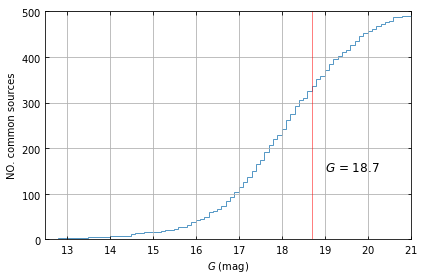

In [5]:
fig, ax = plt.subplots()

bins_array = np.arange(12.5, 21.1, 0.1)

ax.hist(common_source["phot_g_mean_mag"], bins_array, histtype="step", alpha=0.75,
       cumulative=True)
ax.vlines(18.7, 0, 500, lw=0.5, color="r")
ax.axis([12.5, 21, 0, 500])

ax.text(19, 150, "$G$ = 18.7", fontsize=12)

ax.grid()
ax.set_xlabel("$G$ (mag)")
ax.set_ylabel("NO. common sources")

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

fig.tight_layout()
plt.savefig("../plots/comsou-g_icrf1_gaiadr2.eps")

In [34]:
tmp = Table(common_source)
tmp.sort("phot_g_mean_mag")
print("The 100th source corresponds to g={:.2f} mag".format(tmp[99]["phot_g_mean_mag"]))

The 100th source corresponds to g=16.97 mag


Here I divided radio sources into three catagories as done in the ICRF1 catalog, which are 'Defining', 'Candidates', and 'Others'.

In [7]:
# Seperate the sources into the "defining ","Candidates", and "Others".
# Defining sources
mask_def = (common_source["type"] == "D")
com_def = common_source[mask_def]

# Candidate sources
mask_can = (common_source["type"] == "C")
com_can = common_source[mask_can]

# Other sources
mask_oth =  (common_source["type"] == "O")
com_oth = common_source[mask_oth]

The distribution of position offset does not show any bias. 

As for the normalized position offset, no tail at high value could be found but we see a high peak around 0.

This is clearly due to the large formal uncertainty given in the ICRF1 catalog.

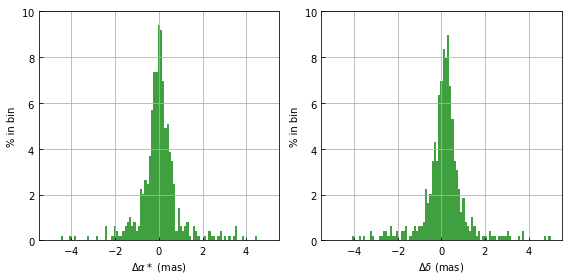

In [8]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

ax0.set_ylim([0, 10])
ax1.set_ylim([0, 10])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

ax0.grid()
ax1.grid()

fig.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

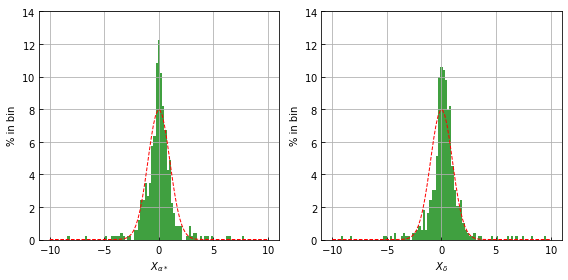

In [9]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylim([0, 13])
ax1.set_ylim([0, 13])

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 15, 2))
ax1.set_yticks(np.arange(0, 15, 2))
ax0.grid()
ax1.grid()

fig.tight_layout()
plt.savefig("../plots/no-dra-ddec_icrf1_gaiadr2.eps")

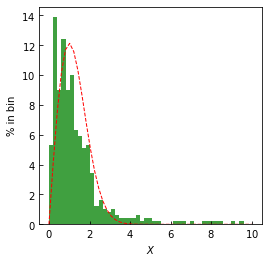

In [10]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

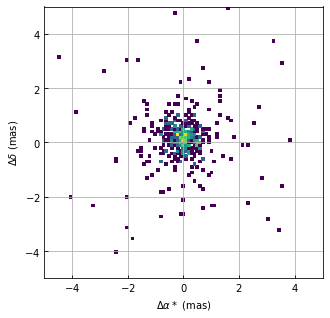

In [11]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-5, 5, 100)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())

ax.set_xlabel("$\Delta\\alpha*$ (mas)")
ax.set_ylabel("$\Delta\\delta$ (mas)")

ax.grid(True)

plt.show()

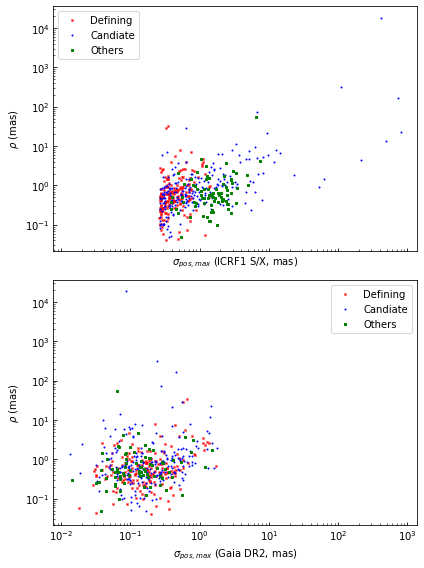

In [12]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(com_def["pos_err_icrf1"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(com_def["pos_err_gaiadr2"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(com_can["pos_err_icrf1"],
         com_can["ang_sep"], "b.", ms=2, label="Candiate")
ax1.plot(com_can["pos_err_gaiadr2"],
         com_can["ang_sep"], "b.", ms=2, label="Candiate")

ax0.plot(com_oth["pos_err_icrf1"],
         com_oth["ang_sep"], "gs", ms=2, label="Others")
ax1.plot(com_oth["pos_err_gaiadr2"],
         com_oth["ang_sep"], "gs", ms=2, label="Others")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (ICRF1 S/X, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (Gaia DR2, mas)")
ax1.set_ylabel("$\\rho$ (mas)")


ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

Then I investigate the systematics through the 16-parameters transformation.

In [13]:
# Try with all the sources
# Transform columns into np.array
dra = np.array(common_source["dra"])
ddec = np.array(common_source["ddec"])
dra_err = np.array(common_source["dra_err"])
ddec_err = np.array(common_source["ddec_err"])
ra_rad = np.array(common_source["ra_icrf1"].to(u.radian))
dec_rad = np.array(common_source["dec_icrf1"].to(u.radian))
dra_ddec_cov = np.array(common_source["dra_ddec_cov"])

# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

Estimates (   490 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1  +738862 +/- 71872  +470127 +/- 71904  -343105 +/- 67832    -325842 +/- 72137  +731718 +/- 66592  +348703 +/- 73737
l_max=2  +540532 +/- 62271  +396185 +/- 59769  -376079 +/- 57577    -175646 +/- 60393  +670632 +/- 55039  +597993 +/- 62757
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22   -49351 37528
            EI22   260187 36432
            ER21    33256 71516
            EI21  -460413 73560
             E20  -725928 69401
            MR22  -344698 38278
         

In [14]:
# The last step is to save the 16 transformation parameters for further use.
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf1_gaiadr2_vsh02_all.log",
             format="ascii", overwrite=True)

For a `clean` sample, I re-estimate the parameters.

In [15]:
# Remove the outlier (consider the normalized separation)
N = len(common_source)
X0 = np.sqrt(np.log(N) * 2)

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((common_source["nor_sep"] <= X0)
        & (common_source["ang_sep"] < 10))

# Table of a clean sample
com_clean = common_source[mask]
N1 = len(com_clean)
print("After elimination, there are %d sources in the clean sample." % N1)
print("The outlier rate is %.0f%%." % ((N-N1)/N*100))

# Take a look at the outliers
from astropy.table import setdiff
com_out = setdiff(common_source, com_clean, keys="iers_name")

print("There are {:d} outliers, among which {:d} are defining sources, "
      "{:d} candidates, and {:d} others.".format(len(com_out), 
                                                 len(com_out[com_out["type"]=="D"]),
                                                 len(com_out[com_out["type"]=="C"]),
                                                 len(com_out[com_out["type"]=="O"])))

There are 490 sources.
When X >= 3.52, the number of the outlier is smaller than 1.
After elimination, there are 447 sources in the clean sample.
The outlier rate is 9%.
There are 43 outliers, among which 23 are defining sources, 17 candidates, and 3 others.


In [16]:
com_out

icrf_name,iers_name,type,ra_icrf1,dec_icrf1,si_s,si_x,ra_err_icrf1,dec_err_icrf1,pos_err_icrf1,ra_dec_corr_icrf1,mean_obs,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_err_gaiadr2,dec_gaiadr2,dec_err_gaiadr2,pos_err_gaiadr2,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep
,,,deg,deg,,,mas,mas,mas,,,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mag,mag,mag,mas,mas,mas,mas,,deg,deg,deg,deg
str16,str8,str1,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
J000557.1+382015,0003+380,D,1.488230870833333,38.33754126944444,--,--,0.482387618423914,0.51,0.5132372638901311,-0.041,2449087.5,2448721.4,2449555.3,2,41,2880735415555982976,1.4882330572178368,0.2284371807502203,38.337539859379994,0.17763597364941844,0.22845829198943232,0.1593562094722022,0.3646175286281955,0.28592281784064194,0.43330939124983037,-0.26680058654512034,0.2873635197110239,-0.010995329,0.39091006,-0.22830355,0.044289686,0.058109067,-0.05278489,0.06332331,-0.313217,0.13932036,-0.18161543,18.399437,18.87687,17.15951,-6.173764763646617,5.076232017131588,0.5337427844550261,0.5400504968374503,-0.010532900844055969,7.992715611642666,-11.566928759421621,9.399550684349212,14.645340650304684
J001331.1+405137,0010+405,D,3.379709220833333,40.86031779722222,2,1,0.29495963311504103,0.33999999999999997,0.34073318132559427,-0.038,2449550.1,2448435.2,2449821.0,7,219,383084664461521536,3.379709059533647,0.30642273194190933,40.86031817758646,0.18262136689914535,0.308104947689734,0.015450318433697707,0.35624755363875243,0.7872298627334215,0.5711080651114665,-0.2178478450070414,0.2812835079111348,-0.14257787,0.3022634,-0.31667477,0.19280086,-0.09837172,0.18864177,-0.4105155,-0.2648572,0.19643839,-0.21485445,19.07663,19.004562,17.54357,0.439171349718924,-1.3693112435930743,0.4253187931635549,0.38594114013423375,-0.011789441794793543,1.4380141710860688,1.032569820045648,-3.5479794745820974,3.6326553443164165
J011343.1+022217,0111+021,C,18.429770641666668,2.371476752777778,--,--,0.34470452579247257,0.38,0.48993817969804354,-0.822,2448461.7,2447024.2,2449668.4,28,160,2538575024852905856,18.429771205611786,0.4948699153499713,2.371475919001008,0.30875120247517185,0.5057566809525936,-0.25884983338366757,0.5788476785430456,-0.33678429171618546,1.2496423054263561,0.44607996921804977,0.5479649777610852,0.27363557,0.14520483,0.0936516,-0.007285472,0.008847135,-0.06715713,0.16390347,-0.21203448,0.05263398,0.3871054,17.247536,16.693443,15.32465,-2.028463664641142,3.0015963714546956,0.6030899130480473,0.4896195513149618,-0.06586266741165822,3.6227400701539945,-3.363451486676643,6.130466733596251,6.463395791804131
J012031.6-270124,0118-272,C,20.131930462499998,-27.023514258333332,--,--,1.6569254434717138,1.1199999999999999,1.8220605255603537,-0.587,2448170.6,2447512.5,2449651.3,2,13,5036556350991034368,20.131929573838484,0.04281276511100022,-27.02351265048754,0.03557267126387657,0.042815580363237314,-0.012184011504084782,0.052660955734931,-0.1489879822675089,0.11453280189358264,-0.1531431679823234,0.08302427898065758,0.0076817414,0.16410425,-0.2737212,0.061856538,0.13143075,0.082894646,-0.5305176,0.07186193,-0.18548349,0.15712096,15.9418335,16.24847,15.371997,2.84989523890637,-5.788244853022206,1.657478463836072,1.1205647749866348,-1.0893173645372454,6.451796753717468,1.7194161499453608,-5.165471003754552,5.412818910490222
J012141.5+114950,0119+115,C,20.4233126708

In [17]:
# Transform columns into np.array
dra = np.array(com_clean["dra"])
ddec = np.array(com_clean["ddec"])
dra_err = np.array(com_clean["dra_err"])
ddec_err = np.array(com_clean["ddec_err"])
ra_rad = np.array(com_clean["ra_icrf1"].to(u.radian))
dec_rad = np.array(com_clean["dec_icrf1"].to(u.radian))
dra_ddec_cov = np.array(com_clean["dra_ddec_cov"])

In [18]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

Estimates (   447 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   +25 +/-  25    -7 +/-  25   +16 +/-  23     -19 +/-  24  +149 +/-  24  +191 +/-  25
l_max=2   +41 +/-  27    +4 +/-  26    +2 +/-  24     -29 +/-  25  +158 +/-  25  +213 +/-  27
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22      -14    16
            EI22       -2    15
            ER21      -45    30
            EI21      -38    31
             E20      -54    31
            MR22       24    17
            MI22      -21    17
            MR21       52    29
     

Save the results for future use.

In [19]:
# The last step is to save the 16 transformation parameters for further use.
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf1_gaiadr2_vsh02.log",
             format="ascii", overwrite=True)

Then I check the residuals of positional offsets.

In [20]:
# Remove the systematics
RA = np.array(common_source["ra_icrf1"].to(u.radian))
DE = np.array(common_source["dec_icrf1"].to(u.radian))

dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)
# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)

# Now re-calculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns = nor_sep_calc(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

In [21]:
# Check if the outlier number is changed.
# Remove the outlier (consider the normalized separation)

print("After removing the global systematics,")
mask_ns = ((X_ns <= X0)& (ang_sep_ns < 10))

# Table of a clean sample
com_clean_ns = common_source[mask_ns]
N1_ns = len(com_clean_ns)
print("After removing the global systematics, "
      "%d sources will stay in the clean sample with the criteria of." % N1_ns)
print("The outlier rate is %.0f%%." % ((N-N1_ns)/N*100))

# Take a look at the outliers
com_out_ns = setdiff(common_source, com_clean_ns, keys="iers_name")

print("There are {:d} outliers, among which {:d} are defining sources, "
      "{:d} candidates, and {:d} others.".format(len(com_out_ns), 
                                                 len(com_out_ns[com_out_ns["type"]=="D"]),
                                                 len(com_out_ns[com_out_ns["type"]=="C"]),
                                                 len(com_out_ns[com_out_ns["type"]=="O"])))

After removing the global systematics,
After removing the global systematics, 446 sources will stay in the clean sample with the criteria of.
The outlier rate is 9%.
There are 44 outliers, among which 24 are defining sources, 17 candidates, and 3 others.


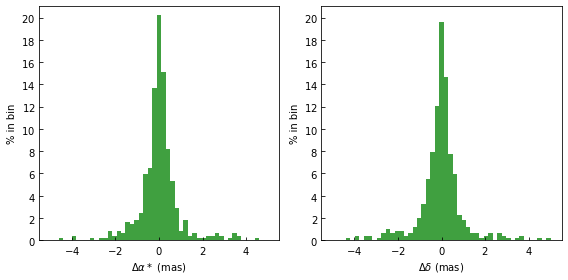

In [22]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 23, 2))
ax1.set_yticks(np.arange(0, 23, 2))

ax0.set_ylim([0, 21])
ax1.set_ylim([0, 21])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

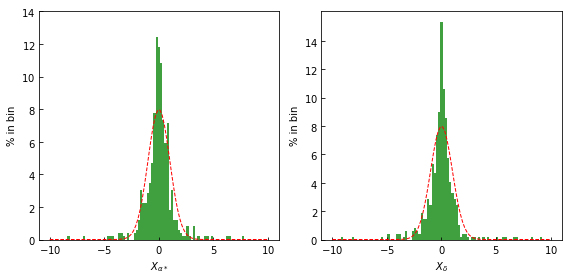

In [23]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 15, 2))
ax1.set_yticks(np.arange(0, 15, 2))

fig.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

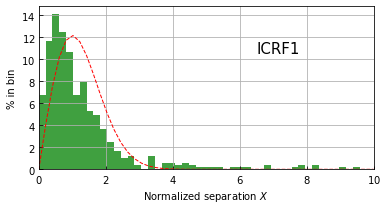

In [24]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.text(6.5, 10.5, "ICRF1", fontsize=15)

ax.set_xlim([0, 10])
ax.set_xlabel("Normalized separation $X$")
ax.set_ylabel("% in bin")
ax.grid()

plt.savefig("../plots/x_icrf1_gaiadr2.eps")

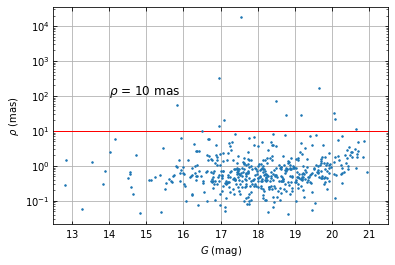

In [25]:
# Distribution of angular separation
fig, ax = plt.subplots()
ax.plot(common_source["phot_g_mean_mag"], common_source["ang_sep"], ".", ms=3)
ax.hlines(10, 12.5, 21.5, "r", lw=1)

ax.text(14, 10+100, "$\\rho$ = 10 mas", fontsize=12)

ax.set_xlim([12.5, 21.5])

ax.set_ylabel("$\\rho$ (mas)")
ax.set_xlabel("$G$ (mag)")

ax.set_yscale("log")

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.grid()
plt.savefig("../plots/angsep-g_icrf1_gaiadr2.eps")

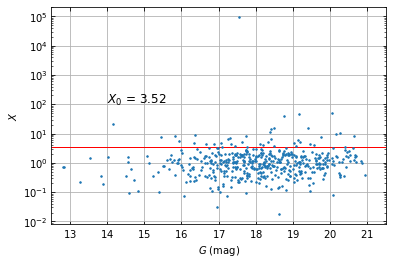

In [26]:
# Distribution of angular separation
fig, ax = plt.subplots()
ax.plot(common_source["phot_g_mean_mag"], common_source["nor_sep"], ".", ms=3)
ax.hlines(X0, 12.5, 21.5, "r", lw=1)

ax.text(14, X0+100, "$X_0$ = {:.2f}".format(X0), fontsize=12)

ax.set_xlim([12.5, 21.5])
ax.set_ylabel("$X$")
ax.set_xlabel("$G$ (mag)")

ax.set_yscale("log")

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.grid()
plt.savefig("../plots/norsep-g_icrf1_gaiadr2.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


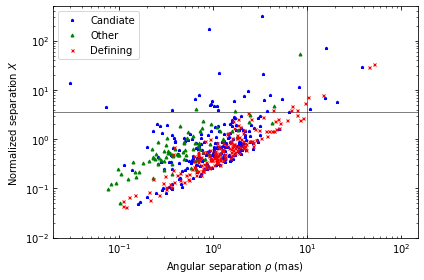

In [27]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(com_can["nor_sep"], com_can["ang_sep"],
         "b*", ms=3, label="Candiate")
ax.plot(com_oth["nor_sep"], com_oth["ang_sep"],
         "g^", ms=3, label="Other")
ax.plot(com_def["nor_sep"], com_def["ang_sep"],
         "rx", ms=3, label="Defining")

ax.vlines(10, 0.01, 500, colors="k", lw=0.5)
ax.hlines(X0, 0.02, 150, colors="k", lw=0.5)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel("Normalized separation $X$")
ax.set_xlabel("Angular separation $\\rho$ (mas)")

ax.set_xlim([0.02, 150])
ax.set_ylim([0.01, 500])
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(loc="upper left")
fig.tight_layout()

plt.savefig("../plots/separation_icrf1_gaiadr2.eps")

In [35]:
# Remove the outlier (consider the normalized separation) 
mask = ((X_ns <= X0)
        & (ang_sep_ns < 10))

# Table of a clean sample
com_clean = common_source[mask]
N2 = len(com_clean)
print("After elimination, there are %d sources in the clean sample." % N1)
print("The outlier rate is %.0f%%." % ((N-N2)/N*100))

# Take a look at the outliers
com_out = setdiff(common_source, com_clean, keys="iers_name")

print("There are {:d} outliers, among which {:d} are defining sources, "
      "{:d} candidates, and {:d} others.".format(len(com_out), 
                                                 len(com_out[com_out["type"]=="D"]),
                                                 len(com_out[com_out["type"]=="C"]),
                                                 len(com_out[com_out["type"]=="O"])))

After elimination, there are 447 sources in the clean sample.
The outlier rate is 9%.
There are 44 outliers, among which 24 are defining sources, 17 candidates, and 3 others.
